# Customer Default Prediction

In [2]:
import os

%matplotlib inline
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import sys
from hashlib import sha1

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import tests_hw5
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

**Problem Description**

A payment default usually happens after multiple payments on a loan or other debt are missed. This project is aimed at predicting the case of customers default payments.

**Dataset**

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

Dataset source: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset?datasetId=306&sortBy=voteCount&language=Python

**Attributes:**
- `ID`: ID of each client
- `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
- `SEX`: Gender (1=male, 2=female)
- `EDUCATION`: Highest education (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- `MARRIAGE`: Marital status (1=married, 2=single, 3=others)
- `AGE`: Age in years

To be more readable, I changed the following column names with their corresponding months:

- `PAY_9`: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- `PAY_8`: Repayment status in August, 2005 (scale same as above)
- `PAY_7`: Repayment status in July, 2005 (scale same as above)
- `PAY_6`: Repayment status in June, 2005 (scale same as above)
- `PAY_5`: Repayment status in May, 2005 (scale same as above)
- `PAY_4`: Repayment status in April, 2005 (scale same as above)
- `BILL_AMT_9`: Amount of bill statement in September, 2005 (NT dollar)
- `BILL_AMT_8`: Amount of bill statement in August, 2005 (NT dollar)
- `BILL_AMT_7`: Amount of bill statement in July, 2005 (NT dollar)
- `BILL_AMT_6`: Amount of bill statement in June, 2005 (NT dollar)
- `BILL_AMT_5`: Amount of bill statement in May, 2005 (NT dollar)
- `BILL_AMT_4`: Amount of bill statement in April, 2005 (NT dollar)
- `PAY_AMT_9`: Amount of previous payment in September, 2005 (NT dollar)
- `PAY_AMT_8`: Amount of previous payment in August, 2005 (NT dollar)
- `PAY_AMT_7`: Amount of previous payment in July, 2005 (NT dollar)
- `PAY_AMT_6`: Amount of previous payment in June, 2005 (NT dollar)
- `PAY_AMT_5`: Amount of previous payment in May, 2005 (NT dollar)
- `PAY_AMT_4`: Amount of previous payment in April

In [3]:
credit_card_df = pd.read_csv("data/UCI_Credit_Card.csv")
credit_card_df = credit_card_df.rename(columns = {'default.payment.next.month':'default_pay',
                                                  'PAY_0':'PAY_9','PAY_2':'PAY_8','PAY_3':'PAY_7','PAY_4':'PAY_6','PAY_5':'PAY_5','PAY_6':'PAY_4',
                                                  'BILL_AMT1': 'BILL_AMT_9','BILL_AMT2': 'BILL_AMT_8','BILL_AMT3': 'BILL_AMT_7','BILL_AMT4': 'BILL_AMT_6','BILL_AMT5': 'BILL_AMT_5','BILL_AMT6': 'BILL_AMT_4',
                                                  'PAY_AMT1': 'PAY_AMT_9','PAY_AMT2': 'PAY_AMT_8','PAY_AMT3': 'PAY_AMT_7','PAY_AMT4': 'PAY_AMT_6','PAY_AMT5': 'PAY_AMT_5','PAY_AMT6': 'PAY_AMT_4'})
credit_card_df.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_9,PAY_8,PAY_7,PAY_6,...,BILL_AMT_6,BILL_AMT_5,BILL_AMT_4,PAY_AMT_9,PAY_AMT_8,PAY_AMT_7,PAY_AMT_6,PAY_AMT_5,PAY_AMT_4,default_pay
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,6,50000.0,1,1,2,37,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
6,7,500000.0,1,1,2,29,0,0,0,0,...,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
7,8,100000.0,2,2,2,23,0,-1,-1,0,...,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0
8,9,140000.0,2,3,1,28,0,0,2,0,...,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0
9,10,20000.0,1,3,2,35,-2,-2,-2,-2,...,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0,0


<!-- END QUESTION -->

<br><br>

## Data Wrangling 

In [4]:
credit_card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           30000 non-null  int64  
 1   LIMIT_BAL    30000 non-null  float64
 2   SEX          30000 non-null  int64  
 3   EDUCATION    30000 non-null  int64  
 4   MARRIAGE     30000 non-null  int64  
 5   AGE          30000 non-null  int64  
 6   PAY_9        30000 non-null  int64  
 7   PAY_8        30000 non-null  int64  
 8   PAY_7        30000 non-null  int64  
 9   PAY_6        30000 non-null  int64  
 10  PAY_5        30000 non-null  int64  
 11  PAY_4        30000 non-null  int64  
 12  BILL_AMT_9   30000 non-null  float64
 13  BILL_AMT_8   30000 non-null  float64
 14  BILL_AMT_7   30000 non-null  float64
 15  BILL_AMT_6   30000 non-null  float64
 16  BILL_AMT_5   30000 non-null  float64
 17  BILL_AMT_4   30000 non-null  float64
 18  PAY_AMT_9    30000 non-null  float64
 19  PAY_

From the `info()`, we can see all columns are the numeric. However, it makes no sense to treat `SEX`, `EDUCATION`, `MARRIAGE` and `default_pay` as numeric since each of them only have limited number of unique values as below shows.

In [5]:
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'default_pay']

for col in categorical_cols:
    print(f"The unique values in column '{col}':\n {credit_card_df[col].unique()}\n")

The unique values in column 'SEX':
 [2 1]

The unique values in column 'EDUCATION':
 [2 1 3 5 4 6 0]

The unique values in column 'MARRIAGE':
 [1 2 3 0]

The unique values in column 'default_pay':
 [1 0]



Since there are some undescribed values in the dataset description, '0, 5, 6' in `EDUCATION` and'0' in `MARRIAGE` , I handled them by labeling them as  'other class'.

In [6]:
credit_card_df.loc[credit_card_df['EDUCATION'].isin([5, 6, 0]), 'EDUCATION'] = 4
print(credit_card_df['EDUCATION'].unique())

credit_card_df.loc[credit_card_df['MARRIAGE'] == 0, 'MARRIAGE'] = 3
print(credit_card_df['MARRIAGE'].unique())

[2 1 3 4]
[1 2 3]


### Checking Missing Data

In [7]:
credit_card_df.isnull().sum()

ID             0
LIMIT_BAL      0
SEX            0
EDUCATION      0
MARRIAGE       0
AGE            0
PAY_9          0
PAY_8          0
PAY_7          0
PAY_6          0
PAY_5          0
PAY_4          0
BILL_AMT_9     0
BILL_AMT_8     0
BILL_AMT_7     0
BILL_AMT_6     0
BILL_AMT_5     0
BILL_AMT_4     0
PAY_AMT_9      0
PAY_AMT_8      0
PAY_AMT_7      0
PAY_AMT_6      0
PAY_AMT_5      0
PAY_AMT_4      0
default_pay    0
dtype: int64

From the above summary, we can confirm that there is no missing value in the dataset.

<!-- END QUESTION -->

<br><br>

### Data Splitting

Since the `ID` column seems not helpful in predicting the target, we choose to get rid of this column.

In [8]:
credit_card_df_cleaned = credit_card_df.drop(columns = "ID")
credit_card_df_cleaned.head(3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_9,PAY_8,PAY_7,PAY_6,PAY_5,...,BILL_AMT_6,BILL_AMT_5,BILL_AMT_4,PAY_AMT_9,PAY_AMT_8,PAY_AMT_7,PAY_AMT_6,PAY_AMT_5,PAY_AMT_4,default_pay
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


In [9]:
train_df, test_df = train_test_split(credit_card_df_cleaned, test_size=0.3, random_state=123)
print(train_df.shape[0])
test_df.shape[0]

21000


9000

There are 21000 rows of data in the training set and 9000 rows in the testing set.

<!-- END QUESTION -->

<br><br>

### Exploratory Data Analysis (EDA)

In [10]:
train_df['MARRIAGE'].value_counts()

2    11210
1     9527
3      263
Name: MARRIAGE, dtype: int64

> 1 = married; 2 = single; 3 = others

It appears that there is a relatively balanced representation between the '1' (married) and '2' (single) categories. However, there is a noticeable shortage of data for the '3' (others) category, which only has 263 entries. This data imbalance may lead to skewed results or inaccurate conclusions when analyzing or making predictions based on this dataset.

In [11]:
train_df['EDUCATION'].value_counts()

2    9815
1    7433
3    3416
4     336
Name: EDUCATION, dtype: int64

> 1 = graduate school, 2 = university, 3 = high school, 4 = others, 

It can be observed that there is a relatively balanced representation between the '1' (graduate school) and '2' (university) categories. However, there is a shortage of data for the '3' (high school) category, which only has 3416 entries. Additionally, the '4' (others) category has even fewer data points, with only 336 entries.

In [12]:
train_df['SEX'].value_counts()

2    12616
1     8384
Name: SEX, dtype: int64

> 1 = male; 2 = female

The amount of data for category '1' is not significantly different from category '2' based on the boxplot.

In [13]:
train_df['default_pay'].value_counts()

0    16312
1     4688
Name: default_pay, dtype: int64

> 1 = yes; 0 = no

There is a noticeable difference between the number of instances in class '0' and class '1' (with more instances in class '0'), as shown in the data provided. This indicates that the variable 'default_pay' has imbalanced data.

We can visualize those differences with the `defualt_pay` categories in the following count plots:

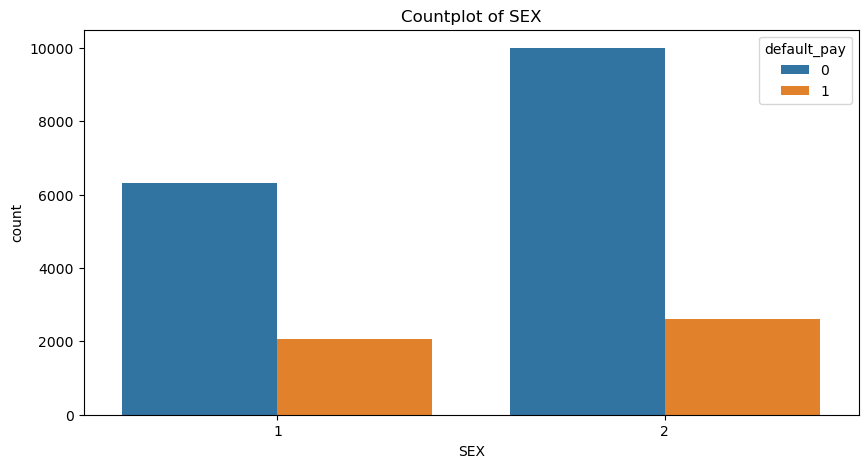

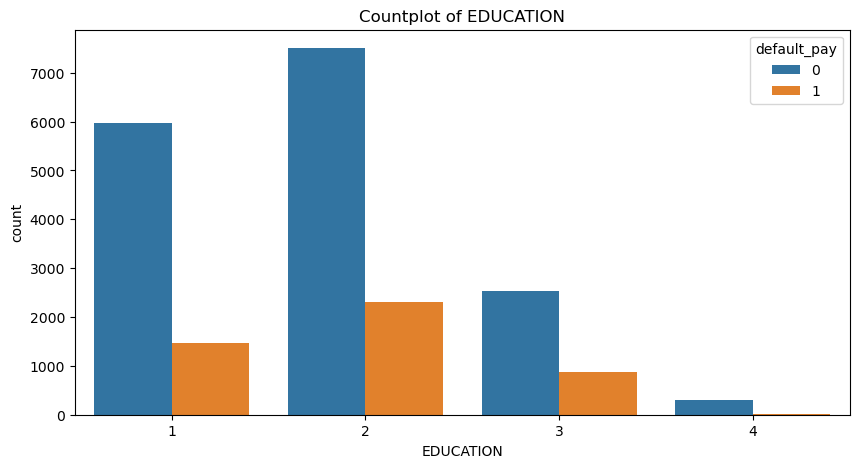

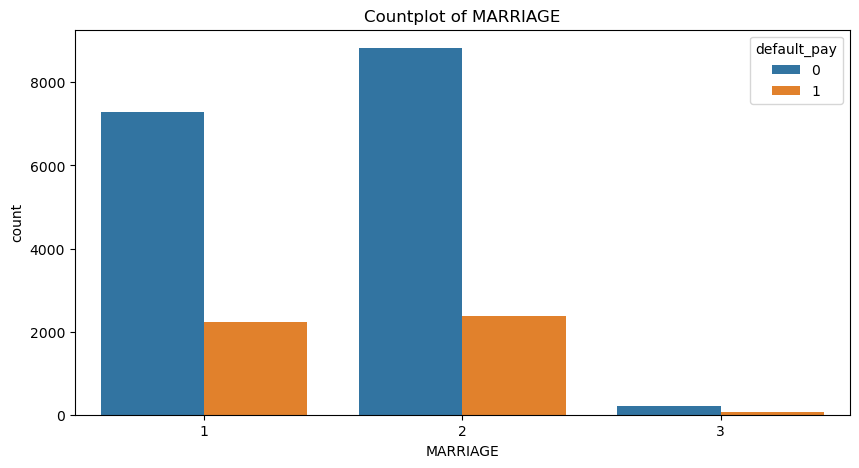

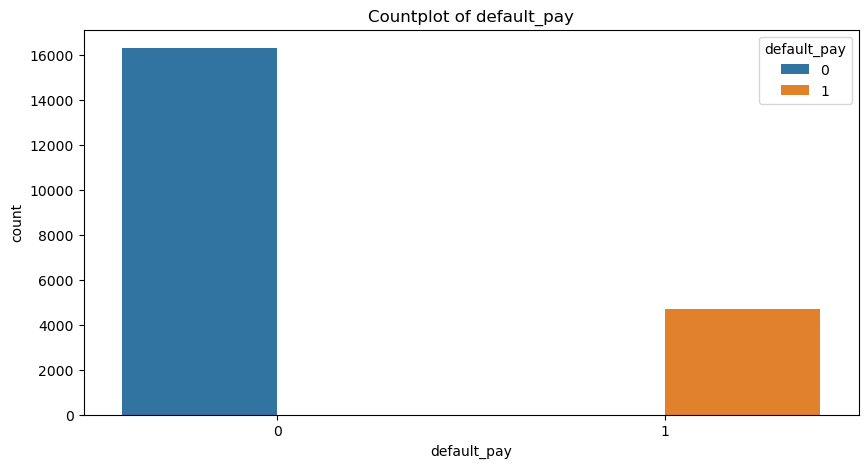

In [14]:
for feat in categorical_cols:
    plt.figure(figsize=(10,5))
    sns.countplot(x = feat, hue = 'default_pay', data = train_df)
    plt.xlabel(feat)
    plt.title("Countplot of " + feat)
    plt.show()

* For `EDUCATION` variable,the category '2' has the highest amount of data for both `default_pay` with category '1' and `default_pay` with category '0'.
* For `MARRIAGE` variable, The category '1' and '2' has a similar amount of data for both `default_pay` with category '1'.
* `SEX` has a similar observation to the `MARRIAGE`

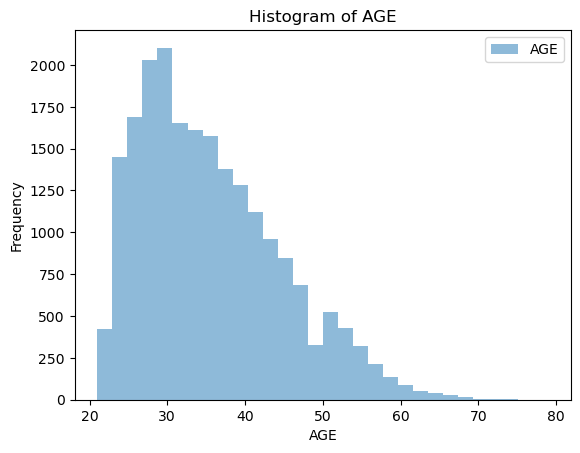

In [15]:
train_df['AGE'].plot.hist(bins=30, alpha=0.5, legend=True)
plt.xlabel('AGE')
plt.title("Histogram of AGE")
plt.show()

The histogram of the `AGE` shows a right skewed distribution with its mean value close to the left side (mean:35.5).

In [16]:
train_df['AGE'].describe()

count    21000.000000
mean        35.500810
std          9.212644
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

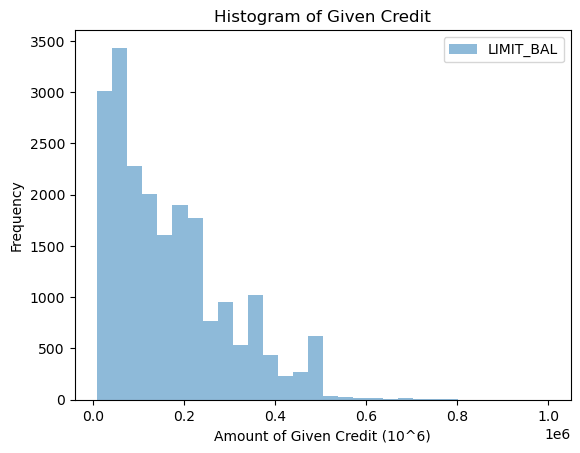

In [17]:
train_df['LIMIT_BAL'].plot.hist(bins=30, alpha=0.5, legend=True)
plt.xlabel('Amount of Given Credit (10^6)')
plt.title("Histogram of Given Credit")
plt.show()

The axis is scaled automatically with 10^6 by the plot function. The histogram of the `LIMIT_BAL` shows a right skewed distribution with its mean value close to the left side (mean:167880.6).

In [18]:
train_df['LIMIT_BAL'].describe()

count      21000.000000
mean      167880.651429
std       130202.682167
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

In summary, I would use all the columns except for the 'ID' column and the target variable 'default_pay' for model training. Additionally, the default classification metric of 'accuracy' should be changed due to the imbalanced categories in the target variable. Both Type I and Type II errors need to be considered. Therefore, the 'precision', 'recall', and 'f1' scores are chosen as the evaluation metrics. These metrics aim to reduce the probability of falsely classifying a client as defaulting on payment when they are not, while also minimizing the probability of falsely classifying a client as non-defaulting when they actually are (as this could lead to a loss of trust in the bank).

In [19]:
scoring_metrics = ['precision', 'recall', 'f1']

<!-- END QUESTION -->

<br><br>

### Feature Engineering

Usually, clients who have not paid their debts are more likely to default. Additionally, clients with a larger remaining payment amount may have a higher probability of defaulting. Therefore, I have added a new feature called `rest_payment` to both the training and testing datasets. This feature represents the amount of money that the client still needs to pay.

In [20]:
mapping = {('BILL_AMT_4', 'PAY_AMT_4'), ('BILL_AMT_5', 'PAY_AMT_5'),
            ('BILL_AMT_6', 'PAY_AMT_6'),('BILL_AMT_7', 'PAY_AMT_7'),
            ('BILL_AMT_8', 'PAY_AMT_8'),('BILL_AMT_9', 'PAY_AMT_9')}

train_df['rest_payment'] = 0
test_df['rest_payment'] = 0

for bill_col, pay_col in mapping:
    train_df['rest_payment'] += train_df[bill_col] - train_df[pay_col]
    test_df['rest_payment'] += test_df[bill_col] - test_df[pay_col]

train_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_9,PAY_8,PAY_7,PAY_6,PAY_5,...,BILL_AMT_5,BILL_AMT_4,PAY_AMT_9,PAY_AMT_8,PAY_AMT_7,PAY_AMT_6,PAY_AMT_5,PAY_AMT_4,default_pay,rest_payment
16395,320000.0,2,1,2,36,0,0,0,0,0,...,10155.0,3788.0,5000.0,5018.0,1000.0,3000.0,0.0,7013.0,0,98182.0
21448,440000.0,2,1,2,30,-1,-1,-1,0,0,...,150897.0,117870.0,612.0,87426.0,130007.0,3018.0,15000.0,51663.0,0,241100.0
20034,160000.0,2,3,1,44,-2,-2,-2,-2,-2,...,-18.0,-18.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-108.0
25755,120000.0,2,2,1,30,0,0,0,0,0,...,71095.0,47379.0,3706.0,5502.0,4204.0,3017.0,2005.0,1702.0,0,510546.0
1438,50000.0,1,2,2,54,1,2,0,0,0,...,27910.0,27380.0,0.0,1400.0,1200.0,1500.0,1000.0,1500.0,0,198481.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28636,380000.0,2,2,1,37,0,0,0,0,0,...,15949.0,15556.0,1204.0,1300.0,1242.0,1900.0,0.0,3000.0,0,78223.0
17730,360000.0,2,1,1,54,1,-2,-2,-1,0,...,2580.0,6941.0,0.0,0.0,2580.0,0.0,6941.0,0.0,0,2580.0
28030,50000.0,2,3,1,29,0,0,0,0,0,...,8824.0,9009.0,2002.0,2000.0,1530.0,1000.0,327.0,329.0,1,192417.0
15725,30000.0,2,2,2,21,0,0,0,0,0,...,29434.0,16565.0,2000.0,2000.0,2000.0,1765.0,331.0,0.0,0,155118.0


<!-- END QUESTION -->

<br><br>

### Preprocessing and Transformations

To avoid the information leakage, specify the X_train and y_train:

In [21]:
X_train = train_df.drop(columns=["default_pay"])
y_train = train_df["default_pay"]

X_test = test_df.drop(columns=["default_pay"])
y_test = test_df["default_pay"]

X_train.columns


Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_9', 'PAY_8',
       'PAY_7', 'PAY_6', 'PAY_5', 'PAY_4', 'BILL_AMT_9', 'BILL_AMT_8',
       'BILL_AMT_7', 'BILL_AMT_6', 'BILL_AMT_5', 'BILL_AMT_4', 'PAY_AMT_9',
       'PAY_AMT_8', 'PAY_AMT_7', 'PAY_AMT_6', 'PAY_AMT_5', 'PAY_AMT_4',
       'rest_payment'],
      dtype='object')

Specify the categorical features, binary features, and numeric features for column transformation:

In [22]:
categorical_features = ["MARRIAGE","EDUCATION"]
binary_features = ["SEX"]
numeric_features = list(set(X_train.columns) 
                     - set(categorical_features)
                     - set(binary_features))
numeric_features

['BILL_AMT_5',
 'PAY_6',
 'PAY_AMT_9',
 'PAY_4',
 'PAY_AMT_6',
 'BILL_AMT_4',
 'BILL_AMT_9',
 'PAY_AMT_7',
 'rest_payment',
 'BILL_AMT_6',
 'PAY_5',
 'PAY_7',
 'BILL_AMT_8',
 'PAY_9',
 'LIMIT_BAL',
 'PAY_8',
 'PAY_AMT_5',
 'AGE',
 'BILL_AMT_7',
 'PAY_AMT_8',
 'PAY_AMT_4']

Since there are only two categories in the `SEX`, we can treat it as a binary variable. 

#### Column Transformation Building:

In [23]:
numeric_transformer = make_pipeline(StandardScaler())

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

binary_transformer = make_pipeline(
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['BILL_AMT_5', 'PAY_6', 'PAY_AMT_9', 'PAY_4',
                                  'PAY_AMT_6', 'BILL_AMT_4', 'BILL_AMT_9',
                                  'PAY_AMT_7', 'rest_payment', 'BILL_AMT_6',
                                  'PAY_5', 'PAY_7', 'BILL_AMT_8', 'PAY_9',
                                  'LIMIT_BAL', 'PAY_8', 'PAY_AMT_5', 'AGE',
                                  'BILL_AMT_7', 'PAY_AMT_8', 'PAY_AMT_4']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>))]),
                                 ['SEX']),
                                ('pipeline-3',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['MARRIAGE', 'EDUCATION'])])

* For all the numeric_features, the StandardScaler was performed to scale all of them to be distributed with mean 0 and standard deviation 1 since they have different ranges.
* For the categorical_features, the OneHotEncoder was performed to convert them into a binary vector representation, which can be understood and processed by machine learning algorithms.
* For the binary_features, the OneHotEncoder with `drop="if_binary"` argument was performed to convert them into a binary vector representation in just one column.

Note: Since there are no missing values, there is no imputation performed.

In [24]:
X_train_pp = preprocessor.fit_transform(X_train)

column_names = (numeric_features + binary_features
                + list(preprocessor.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out()))

<!-- END QUESTION -->

<br><br>

### Models

#### Baseline Model

All the following parts will use this function to calculate the mean cross-validation score to compare the models. This function is from the CPSC330's lecture notebooks.

In [25]:
results = {}

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append(("%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [26]:
Dummy_pipe = make_pipeline(preprocessor, DummyClassifier())
Dummy_pipe.fit(X_train,y_train)
dummy_score = Dummy_pipe.score(X_train,y_train)
dummy_score

0.7767619047619048

The dummy classifier uses the baseline of the most frequent category in the `y_train` to do the prediction. The output of dummy_score is the proportion of the most frequent class among the training set, which is the proportion of the category '0'. Check it below:

In [27]:
proportion_0 = (pd.DataFrame(y_train)['default_pay'] == 0).mean()

dummy_score == proportion_0

True

Also, the `DummyClassifier` returns the score of 'accuracy' rather than the 'recall'. Since there is no scoring argument in `DummyClassifier` for changing the scoring metric, we need cross-validation to change the scoring metric to get those metric scores and get a more reliable estimate of the model performance.

<!-- END QUESTION -->



In [28]:
dummy_corss_scores = mean_std_cross_val_scores(Dummy_pipe, X_train, y_train, scoring=scoring_metrics)
dummy_corss_scores

/Users/haojiang/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haojiang/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haojiang/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haojiang/miniconda3/envs/cpsc330/

fit_time          0.014 (+/- 0.001)
score_time        0.007 (+/- 0.001)
test_precision    0.000 (+/- 0.000)
test_recall       0.000 (+/- 0.000)
test_f1           0.000 (+/- 0.000)
dtype: object

Since the most frequent class is not '1' (the positive class) and all rows of class '1' would be wrongly predicted as the class '0', it is expected that the recall of the dummy model is 0.

<br><br>

#### Linear Models

Since our target `default_pay` is a binary variable, the Logistic Regression model was used to classify it. Also, `class_weight`='balanced' is used to handle the imbalance issue of the data since the probability of falsely classifying the client who will default payment to a non-default category is aimed to decrease. 

In [29]:
lr_pipe = make_pipeline(preprocessor,  LogisticRegression(class_weight="balanced", max_iter = 1000, random_state=123))
lr_cross_scores = mean_std_cross_val_scores(lr_pipe, X_train, y_train, return_train_score=True, scoring = scoring_metrics)
lr_cross_scores

fit_time           0.085 (+/- 0.026)
score_time         0.008 (+/- 0.001)
test_precision     0.378 (+/- 0.007)
train_precision    0.381 (+/- 0.003)
test_recall        0.648 (+/- 0.020)
train_recall       0.649 (+/- 0.005)
test_f1            0.478 (+/- 0.008)
train_f1           0.480 (+/- 0.003)
dtype: object

The mean cross-validation recall score of Logistic Regression based on the default C is 0.648 and the mean cross-validation f1 score is 0.478.

##### Hyperparameter Tuning

Even though choosing the best model by trade-off on those three scores (precision, recall, and f1), we decided to take care more of Type II error to get a higher true positive rate for detection and chose the 'recall' as the metric for the hyperparameter tuning/optimization.

In [30]:
score = "recall"

In [31]:
from scipy.stats import uniform
param_dist = {
    "logisticregression__C": [0.001, 0.1, 1.0, 5, 10, 50, 100]
}

random_search = RandomizedSearchCV(lr_pipe, param_distributions=param_dist, scoring=score, n_iter=30, random_state=51)
random_search.fit(X_train, y_train)
relevant = ['mean_test_score',
             'param_logisticregression__C',
             'mean_fit_time',
             'rank_test_score',
             'std_test_score',]
pd.DataFrame(random_search.cv_results_)[relevant].set_index("rank_test_score").sort_index().T


/Users/haojiang/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 7 is smaller than n_iter=30. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


rank_test_score,1,2,2,2,2,6,7
mean_test_score,0.647605,0.647392,0.647392,0.647392,0.647392,0.646112,0.621586
param_logisticregression__C,1.0,5,10,50,100,0.1,0.001
mean_fit_time,0.083281,0.06964,0.071288,0.070562,0.071297,0.091422,0.035355
std_test_score,0.017546,0.017871,0.017871,0.017871,0.017871,0.017923,0.01924


Based on the possible values [0.001, 0.01, 0.4, 1.0, 10, 100], the Logistic Regression model with `C` = 1 has the highest mean cross-validation recall score (0.648) which is the same as the Logistic Regression model with the default `C` = 1. Thus, the model with `C` = 1 is the best linear model.

In [32]:
best_lr_pipe = make_pipeline(preprocessor, LogisticRegression(class_weight="balanced", C = 1, max_iter = 1000))

*Note: Even though we used the RandomizedSearchCV for optimization, it actually does the same thing as the GridSearch here since the lack of knowledge of the distribution or range for the hyperparameters.*

<!-- END QUESTION -->

<br><br>

#### Extra Models

In [33]:
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

To avoid breaking the golden rule, we built different pipes for each models. We chose the Supporting Vector with rbf, the Random Forest, the XGBoost, and the CatBoost Classifiers to see how would the non-linear model perform.

In [34]:
svc_pipe = make_pipeline(preprocessor, SVC(class_weight='balanced'))
rf_pipe = make_pipeline(preprocessor, RandomForestClassifier(class_weight='balanced',random_state=123, n_jobs=-1))
xgb_pipe = make_pipeline(preprocessor, XGBClassifier(class_weight='balanced',random_state=123, eval_metric="logloss", verbosity=0))
catboost_pipe = make_pipeline(preprocessor, CatBoostClassifier(class_weights=[1,3],verbose=0, random_state=123))

In [35]:
y_train_counts = pd.Series(y_train).value_counts()
ratio = y_train_counts[0] / y_train_counts[1]
ratio

3.4795221843003414

As shown in the EDA, class '0' has more observations than the class '1'. We get the exact ratio that class '0' is 3.4795 of class '1'. Since there's no class_weight='balanced' argument in the CatBoostClassifier, we balance their weights manually.

In [36]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
classifiers = {
    "Dummy": Dummy_pipe,
    "Logistic Regression": lr_pipe,
    "SVC rbf": svc_pipe,
    "Random Forest": rf_pipe,
    "XGBoost": xgb_pipe,
    "CatBoost": catboost_pipe,
}

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

for name, model in classifiers.items():
    results[name] = mean_std_cross_val_scores(model, X_train, y_train,
                                       scoring = scoring_metrics, return_train_score=True)
    
warnings.filterwarnings("default", category=UndefinedMetricWarning)

#### Summary:

In [37]:
pd.DataFrame(results).T

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
Dummy,0.014 (+/- 0.000),0.017 (+/- 0.022),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression,0.081 (+/- 0.023),0.008 (+/- 0.000),0.378 (+/- 0.007),0.381 (+/- 0.003),0.648 (+/- 0.020),0.649 (+/- 0.005),0.478 (+/- 0.008),0.480 (+/- 0.003)
SVC rbf,13.122 (+/- 0.640),3.184 (+/- 0.222),0.509 (+/- 0.021),0.528 (+/- 0.003),0.580 (+/- 0.009),0.607 (+/- 0.002),0.542 (+/- 0.016),0.565 (+/- 0.002)
Random Forest,1.018 (+/- 0.508),0.035 (+/- 0.003),0.658 (+/- 0.034),0.997 (+/- 0.000),0.345 (+/- 0.008),1.000 (+/- 0.000),0.453 (+/- 0.014),0.999 (+/- 0.000)
XGBoost,1.005 (+/- 0.048),0.011 (+/- 0.001),0.637 (+/- 0.020),0.918 (+/- 0.009),0.369 (+/- 0.013),0.622 (+/- 0.012),0.467 (+/- 0.014),0.741 (+/- 0.011)
CatBoost,4.491 (+/- 0.157),0.033 (+/- 0.003),0.523 (+/- 0.016),0.640 (+/- 0.004),0.571 (+/- 0.010),0.756 (+/- 0.004),0.546 (+/- 0.013),0.693 (+/- 0.003)


We can see the Logistic Regression model has the highest validation recall score but not too high validation f1 score and a very low precision score. The SVC RBF model has the second-highest validation recall score, the second-highest f1 score, and a good precision score without concern about the overfitting issue. I would say the SVC RBF model seems to perform better than the linear model and it's almost the best one for right now. Since the above cross-validation results are based on their default hyperparameter values, we can process the hyperparameter optimization below and redo it for comparison.

<!-- END QUESTION -->

<br><br>

### Feature Selection

In [38]:
from sklearn.feature_selection import RFECV

rfe_pipe = make_pipeline(
    StandardScaler(),
    RFECV(LogisticRegression(max_iter=2000), cv=10),
    RandomForestClassifier(n_estimators=100, random_state=123, n_jobs=-1),
)

pd.DataFrame(cross_validate(rfe_pipe, X_train, y_train, return_train_score=True, scoring= 'f1')).mean()

fit_time       4.615298
score_time     0.021935
test_score     0.441880
train_score    0.443702
dtype: float64

In [39]:
X_train_enc= pd.DataFrame(X_train_pp, columns=column_names, index=X_train.index)

rfe_cv = RFECV(LogisticRegression(max_iter=2000), cv=10)
rfe_cv.fit(X_train_enc, y_train)
print(rfe_cv.support_)
print(X_train_enc.columns[rfe_cv.support_])

[False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False  True]
Index(['PAY_9', 'EDUCATION_4'], dtype='object')


By the Recursive feature elimination (RFE), these two 'PAY_9' and 'EDUCATION_4' features seem the most important features.

<!-- END QUESTION -->

<br><br>

### Hyperparameter Optimization

For the more fair model comparison, we can optimize their hyperparameters and do the cross-validation again to compare them. All the criteria would be consistent as the hyperparameter tuning for the logistic regression.

#### SVC rbf 

In [40]:
param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.1, 0.01, 0.001]
}

random_search_svc = RandomizedSearchCV(
    svc_pipe, param_grid_svc, cv=3, n_jobs=-1, scoring=score, return_train_score=True, random_state=123
)

random_search_svc.fit(X_train, y_train)

relevant = ['mean_test_score',
             'param_svc__C',
             'param_svc__gamma',
             'mean_fit_time',
             'rank_test_score',
             'std_test_score',]
pd.DataFrame(random_search_svc.cv_results_)[relevant].set_index("rank_test_score").sort_index().head()

/Users/haojiang/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,mean_test_score,param_svc__C,param_svc__gamma,mean_fit_time,std_test_score
rank_test_score,,,,,
1,0.580628,10,0.01,15.252858,0.010709
2,0.579348,1,0.1,12.992549,0.013143
3,0.571670,0.1,0.1,13.816106,0.006574
4,0.569111,1,0.01,12.535818,0.005458
5,0.544153,10,0.1,17.531241,0.006456


From random search cross-validation, we can see the SVC with C = 10 and gamma = 0.01 get the highest validation recall score of 0.580628 which is slightly higher than the default one of 0.580 but it might be due to the decimal difference.

In [41]:
best_svc_pipe = make_pipeline(preprocessor, SVC(C=10, gamma = 0.01, class_weight='balanced'))

#### Random Forest 

In [42]:
random_grid_rf = [{'randomforestclassifier__criterion': ['gini', 'entropy'],
                'randomforestclassifier__min_samples_leaf': [5, 10, 20, 30, 50, 80, 100],
                'randomforestclassifier__max_depth': [3, 4, 6, 8, 10],
                'randomforestclassifier__min_samples_split': [2, 4, 6, 8, 10]}]

grid_search_rf = RandomizedSearchCV(
    rf_pipe, random_grid_rf, cv = 3,n_jobs = -1,scoring=score,return_train_score=True, n_iter = 50, random_state=123

)
grid_search_rf.fit(X_train, y_train)

relevant = ['mean_test_score',
             'param_randomforestclassifier__criterion',
             'param_randomforestclassifier__min_samples_leaf',
             'param_randomforestclassifier__max_depth',
             'param_randomforestclassifier__min_samples_split',
             'mean_fit_time',
             'rank_test_score',
             'std_test_score',]
pd.DataFrame(grid_search_rf.cv_results_)[relevant].set_index("rank_test_score").sort_index().head()

,mean_test_score,param_randomforestclassifier__criterion,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_split,mean_fit_time,std_test_score
rank_test_score,,,,,,,
1,0.627555,entropy,100,10,6,2.152874,0.015320
2,0.627129,gini,100,10,8,1.818543,0.014536
2,0.627129,gini,100,10,4,1.806336,0.014536
4,0.625209,entropy,80,10,2,2.167130,0.014372
5,0.623290,entropy,80,8,8,2.118293,0.013252


From random search cross-validation, we can see the Random Forest with criterion = 'gini', min_sample_leaf = 100, max_depth = 10, and min_samples_split = 8 get the highest validation recall score of 0.626703 which is significantly higher than the default one 0.350.

In [43]:
best_rf_pipe = make_pipeline(preprocessor, 
                             RandomForestClassifier(
                                 criterion='gini', 
                                 class_weight='balanced',
                                 min_samples_leaf=100,
                                 max_depth=10,
                                 min_samples_split=8,
                                 random_state=123, 
                                 n_jobs=-1)
                            )

#### XGBoost

In [44]:
random_grid_xgb = {
    'xgbclassifier__n_estimators': [100, 200, 500],
    'xgbclassifier__learning_rate': [0.01, 0.05, 0.1]
}

random_search_xgb = RandomizedSearchCV(
    xgb_pipe, random_grid_xgb, cv = 3,n_jobs = -1,scoring=score,return_train_score=True, random_state=123
)

random_search_xgb.fit(X_train, y_train)

relevant = ['mean_test_score',
             'param_xgbclassifier__n_estimators',
             'param_xgbclassifier__learning_rate',
             'mean_fit_time',
             'rank_test_score',
             'std_test_score',]
pd.DataFrame(random_search_xgb.cv_results_)[relevant].set_index("rank_test_score").sort_index().head()

/Users/haojiang/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,mean_test_score,param_xgbclassifier__n_estimators,param_xgbclassifier__learning_rate,mean_fit_time,std_test_score
rank_test_score,,,,,
1,0.367750,500,0.05,16.174129,0.008996
2,0.367536,500,0.1,14.087436,0.007319
3,0.367322,500,0.01,17.005584,0.007295
4,0.366897,200,0.1,7.032989,0.008559
5,0.366468,200,0.01,7.355061,0.004882


From random search cross-validation, we can see the XGBoost with n_estimators = 100 and learning_rate = 0.1 get the highest validation recall score of 0.368817 which is slightly lower than the default one of 0.369 but it might be due to the decimal difference and the limitation of the possible values for searching. Thus, we will choose the default one since it's simpler.

In [45]:
best_xgb_pipe = xgb_pipe

#### CatBoost

In [46]:
random_grid_catboost = {
    'catboostclassifier__iterations': [100, 200, 500],
    'catboostclassifier__learning_rate': [0.01, 0.05, 0.1],
    'catboostclassifier__depth': [4, 6, 8, 10]
}

grid_search_catboost = RandomizedSearchCV(
    catboost_pipe, random_grid_catboost, cv = 3, n_jobs=-1, scoring=score, return_train_score=True, n_iter = 50, random_state=123
)

grid_search_catboost.fit(X_train, y_train)

relevant = ['mean_test_score',
             'param_catboostclassifier__iterations',
             'param_catboostclassifier__learning_rate',
             'param_catboostclassifier__depth',
             'mean_fit_time',
             'rank_test_score',
             'std_test_score']

pd.DataFrame(grid_search_catboost.cv_results_)[relevant].set_index("rank_test_score").sort_index().head()

/Users/haojiang/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,mean_test_score,param_catboostclassifier__iterations,param_catboostclassifier__learning_rate,param_catboostclassifier__depth,mean_fit_time,std_test_score
rank_test_score,,,,,,
1,0.587028,500,0.05,4,4.624572,0.010159
2,0.584682,200,0.05,4,1.896583,0.009515
3,0.584041,200,0.1,4,1.893501,0.010397
4,0.584041,100,0.1,6,1.244653,0.011069
5,0.582549,200,0.1,6,2.919010,0.006764


From random search cross-validation, we can see the CatBoost with n_estimators = 200, learning_rate = 0.1, and depth = 4 get the highest validation recall score of 0.590868 which is slightly higher than the default one of 0.575.

In [47]:
best_catboost_pipe = make_pipeline(preprocessor, CatBoostClassifier(class_weights=[1,3],iterations = 200, learning_rate = 0.1, depth = 4,verbose=0, random_state=123))

#### Summary

In [48]:
classifiers = {
    "Dummy": Dummy_pipe,
    "Logistic Regression": best_lr_pipe,
    "SVC rbf": best_svc_pipe,
    "Random Forest": best_rf_pipe,
    "XGBoost": best_xgb_pipe,
    "CatBoost": best_catboost_pipe,
}
new_results = {}
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

for name, model in classifiers.items():
    new_results[name] = mean_std_cross_val_scores(model, X_train, y_train,
                                       scoring = scoring_metrics, return_train_score=True)
    
warnings.filterwarnings("default", category=UndefinedMetricWarning)
pd.DataFrame(new_results).T

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
Dummy,0.014 (+/- 0.002),0.007 (+/- 0.001),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression,0.074 (+/- 0.020),0.007 (+/- 0.000),0.378 (+/- 0.007),0.381 (+/- 0.003),0.648 (+/- 0.020),0.649 (+/- 0.005),0.478 (+/- 0.008),0.480 (+/- 0.003)
SVC rbf,13.707 (+/- 0.138),3.023 (+/- 0.023),0.501 (+/- 0.015),0.519 (+/- 0.004),0.580 (+/- 0.010),0.601 (+/- 0.004),0.538 (+/- 0.010),0.557 (+/- 0.003)
Random Forest,0.499 (+/- 0.029),0.034 (+/- 0.003),0.483 (+/- 0.017),0.496 (+/- 0.005),0.631 (+/- 0.016),0.650 (+/- 0.001),0.547 (+/- 0.017),0.563 (+/- 0.004)
XGBoost,0.844 (+/- 0.007),0.010 (+/- 0.001),0.637 (+/- 0.020),0.918 (+/- 0.009),0.369 (+/- 0.013),0.622 (+/- 0.012),0.467 (+/- 0.014),0.741 (+/- 0.011)
CatBoost,0.762 (+/- 0.015),0.032 (+/- 0.002),0.519 (+/- 0.024),0.547 (+/- 0.006),0.589 (+/- 0.009),0.628 (+/- 0.005),0.552 (+/- 0.017),0.585 (+/- 0.005)


In [49]:
pd.DataFrame(results).T

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
Dummy,0.014 (+/- 0.000),0.017 (+/- 0.022),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression,0.081 (+/- 0.023),0.008 (+/- 0.000),0.378 (+/- 0.007),0.381 (+/- 0.003),0.648 (+/- 0.020),0.649 (+/- 0.005),0.478 (+/- 0.008),0.480 (+/- 0.003)
SVC rbf,13.122 (+/- 0.640),3.184 (+/- 0.222),0.509 (+/- 0.021),0.528 (+/- 0.003),0.580 (+/- 0.009),0.607 (+/- 0.002),0.542 (+/- 0.016),0.565 (+/- 0.002)
Random Forest,1.018 (+/- 0.508),0.035 (+/- 0.003),0.658 (+/- 0.034),0.997 (+/- 0.000),0.345 (+/- 0.008),1.000 (+/- 0.000),0.453 (+/- 0.014),0.999 (+/- 0.000)
XGBoost,1.005 (+/- 0.048),0.011 (+/- 0.001),0.637 (+/- 0.020),0.918 (+/- 0.009),0.369 (+/- 0.013),0.622 (+/- 0.012),0.467 (+/- 0.014),0.741 (+/- 0.011)
CatBoost,4.491 (+/- 0.157),0.033 (+/- 0.003),0.523 (+/- 0.016),0.640 (+/- 0.004),0.571 (+/- 0.010),0.756 (+/- 0.004),0.546 (+/- 0.013),0.693 (+/- 0.003)


In summary, the Random Forest has the most significant improvement after the hyperparameter optimization. It has solved the overfitting issue and got the best performance. Even though it just has the second-highest validation recall score, the f1 score is also the second highest and the precision is not too low. Considering both the Type II and Type I errors, the Random Forest with the optimized hyperparameters seems the best choice.

<!-- END QUESTION -->

<br><br>

### Interpretation and Feature Importances

In [50]:
import shap
from lightgbm.sklearn import LGBMClassifier

In [51]:
X_train_enc= pd.DataFrame(X_train_pp, columns=column_names, index=X_train.index)
X_train_enc

,BILL_AMT_5,PAY_6,PAY_AMT_9,PAY_4,PAY_AMT_6,BILL_AMT_4,BILL_AMT_9,PAY_AMT_7,rest_payment,BILL_AMT_6,...,PAY_AMT_8,PAY_AMT_4,SEX,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4
16395,-0.494781,0.192754,-0.039546,0.257059,-0.114944,-0.587035,-0.300665,-0.234603,-0.384446,-0.371930,...,-0.040229,0.097991,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
21448,1.805461,0.192754,-0.297166,0.257059,-0.113778,1.327534,-0.685307,6.785208,0.007729,1.970295,...,3.739796,2.562606,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
20034,-0.661045,-1.518801,-0.333097,-1.485154,-0.309323,-0.650908,-0.696132,-0.289017,-0.654158,-0.670935,...,-0.270403,-0.289117,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
25755,0.501203,0.192754,-0.115517,0.257059,-0.113843,0.144527,0.687456,-0.060260,0.747102,0.918719,...,-0.018028,-0.195169,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1438,-0.204599,0.192754,-0.333097,0.257059,-0.212134,-0.191104,-0.040230,-0.223720,-0.109220,-0.245237,...,-0.206185,-0.206319,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28636,-0.400085,0.192754,-0.262410,1.999273,-0.186216,-0.389539,-0.513226,-0.221435,-0.439214,-0.450259,...,-0.210772,-0.123521,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
17730,-0.618584,-0.663024,-0.333097,-0.614047,-0.309323,-0.534120,-0.695886,-0.148629,-0.646782,-0.630868,...,-0.270403,-0.289117,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
28030,-0.516534,0.192754,-0.215559,0.257059,-0.244530,-0.499414,-0.053288,-0.205764,-0.125860,-0.062716,...,-0.178663,-0.270957,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
15725,-0.179691,0.192754,-0.215677,0.257059,-0.194963,-0.372606,-0.309066,-0.180189,-0.228210,-0.195023,...,-0.178663,-0.289117,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


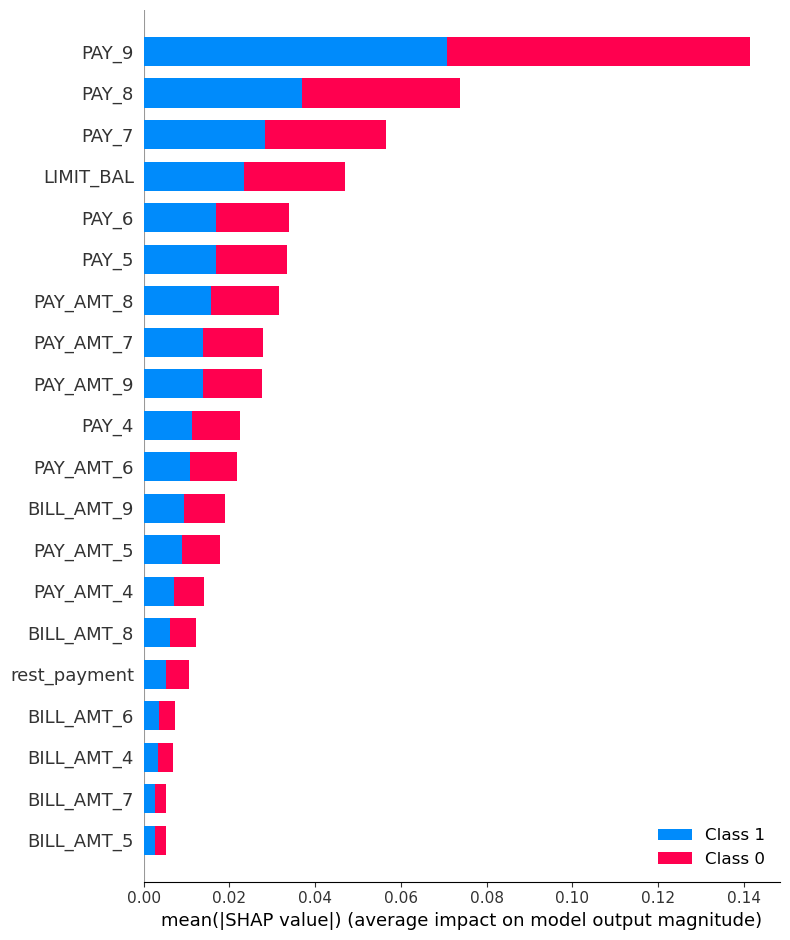

In [52]:
best_rf_pipe.fit(X_train, y_train)

rf_explainer = shap.TreeExplainer(best_rf_pipe.named_steps["randomforestclassifier"])
train_rf_shap_values = rf_explainer.shap_values(X_train_enc)
shap.summary_plot(train_rf_shap_values, X_train_enc)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


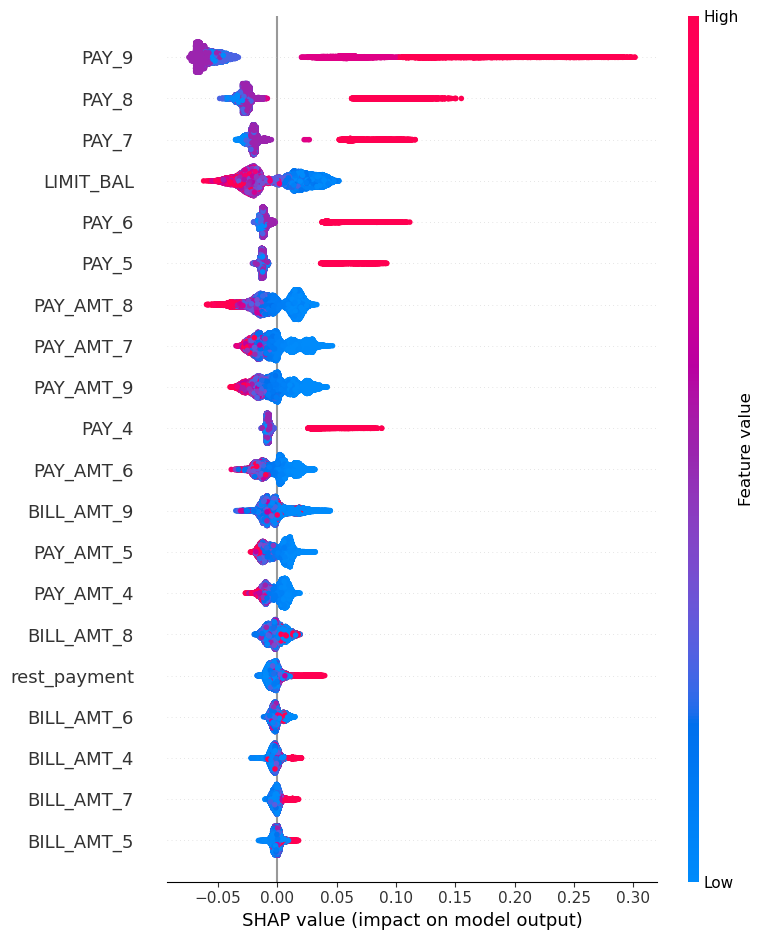

In [53]:
shap.summary_plot(train_rf_shap_values[1], X_train_enc)

In [54]:
import eli5

eli5_rf = eli5.explain_weights(
    best_rf_pipe.named_steps["randomforestclassifier"], feature_names= column_names
)
eli5_rf

Weight,Feature
0.2735 ± 0.3753,PAY_9
0.1407 ± 0.3247,PAY_8
0.1092 ± 0.3118,PAY_7
0.0599 ± 0.2041,PAY_6
0.0585 ± 0.2019,PAY_5
0.0421 ± 0.0825,LIMIT_BAL
0.0364 ± 0.0818,PAY_AMT_9
0.0343 ± 0.0700,PAY_AMT_8
0.0343 ± 0.1337,PAY_4
0.0300 ± 0.0517,PAY_AMT_7


PAY_9 is the most important feature relying on the RandomForestClassifier. Feature PAY_9 has the widest bar representing that the average impact on model output magnitude is significantly influenced by this feature. PAY_n features are important to the model. The series of BILL_AMT_n becomes the less important feature. SEX, MARRIAGE, and EDUCATION do not seem to be an impact on model output. It is noteworthy that our engineered feature rest_payment can not be an impact factor during using the RandomForestClassifier.

<!-- END QUESTION -->

<br><br>

### Results on the test set

In [55]:
best_score_rf= grid_search_rf.best_score_

pred = best_rf_pipe.predict(X_test)
test_score_f1 = f1_score(y_test, pred)
test_score_recall = recall_score(y_test, pred)
test_score_precision = precision_score(y_test, pred)

print("best_score_rf:", best_score_rf)
print("test_score_f1:", test_score_f1)
print("test_score_recall", test_score_recall)
print("test_score_precision", test_score_precision)

best_score_rf: 0.6275551874616512
test_score_f1: 0.5282689369133377
test_score_recall 0.6211498973305954
test_score_precision 0.4595518420053171


test_score_recall is 0.620 and validation scores 0.627 which are very similar, which suggests that the models generalize well. The similarity between the test_score_recall and validation also suggests that we don't have a significant overfitting problem. By using hard predictions, we only obtain the class label, whereas 'predict_proba' provides probability scores instead of just the sign.

Since our dataset is small, the validation set might have been sampled too frequently, leading to optimization bias.

In [56]:
X_test_enc = pd.DataFrame(
    data= preprocessor.transform(X_test),
    columns= column_names,
    index= X_test.index,
)

test_rf_shap_values = rf_explainer.shap_values(X_test_enc)

In [57]:
not_default_indices, default_indices = y_test.reset_index().groupby('default_pay').indices.values()
not_default_indices, default_indices

(array([   0,    1,    4, ..., 8996, 8997, 8999]),
 array([   2,    3,   10, ..., 8993, 8995, 8998]))

In [58]:
ex_not_default_index = not_default_indices[10]
ex_not_default_index

17

In [59]:
print("Probabilities of prediction: ",best_rf_pipe.named_steps["randomforestclassifier"].predict_proba(X_test_enc)[ex_not_default_index])
print("Prediction: ",best_rf_pipe.named_steps["randomforestclassifier"].predict(X_test_enc)[ex_not_default_index])

print("base value", rf_explainer.expected_value[1])

Probabilities of prediction:  [0.76183677 0.23816323]
Prediction:  0
base value 0.5005639899492957


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


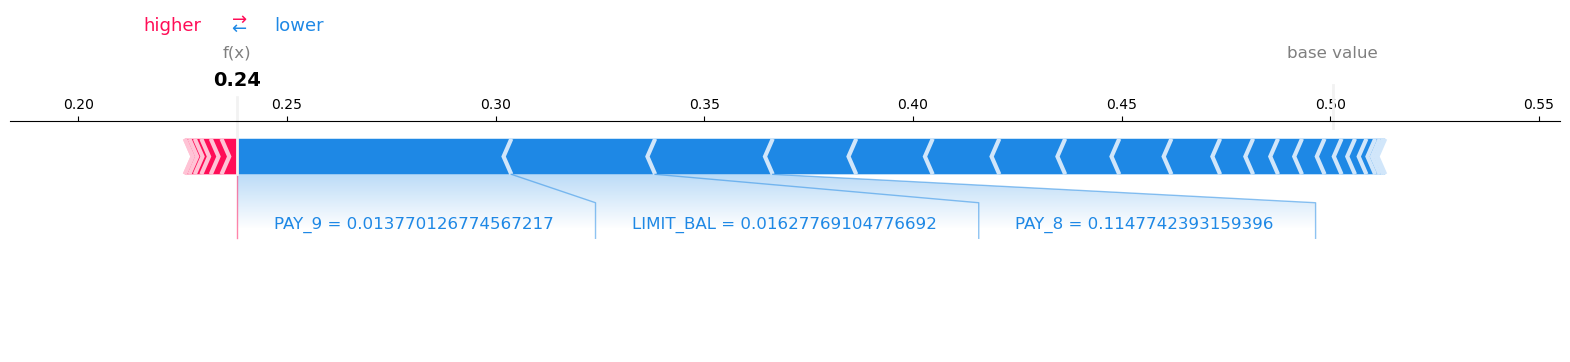

In [ ]:
shap.force_plot(
    base_value=rf_explainer.expected_value[0],
    shap_values=test_rf_shap_values[0][ex_not_default_index, :],
    features=X_test_enc.iloc[ex_not_default_index, :],
    matplotlib=True,
)

The prediction is pushed by the main factors from the base value to the class 0. In this example, the client will likely not default. 

In [61]:
ex_default_index = default_indices[10]
ex_default_index

40

In [62]:
print("Probabilities of prediction: ",best_rf_pipe.named_steps["randomforestclassifier"].predict_proba(X_test_enc)[ex_default_index])
print("Prediction: ",best_rf_pipe.named_steps["randomforestclassifier"].predict(X_test_enc)[ex_default_index])

print("base value", rf_explainer.expected_value[1])

Probabilities of prediction:  [0.29325922 0.70674078]
Prediction:  1
base value 0.5005639899492957


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


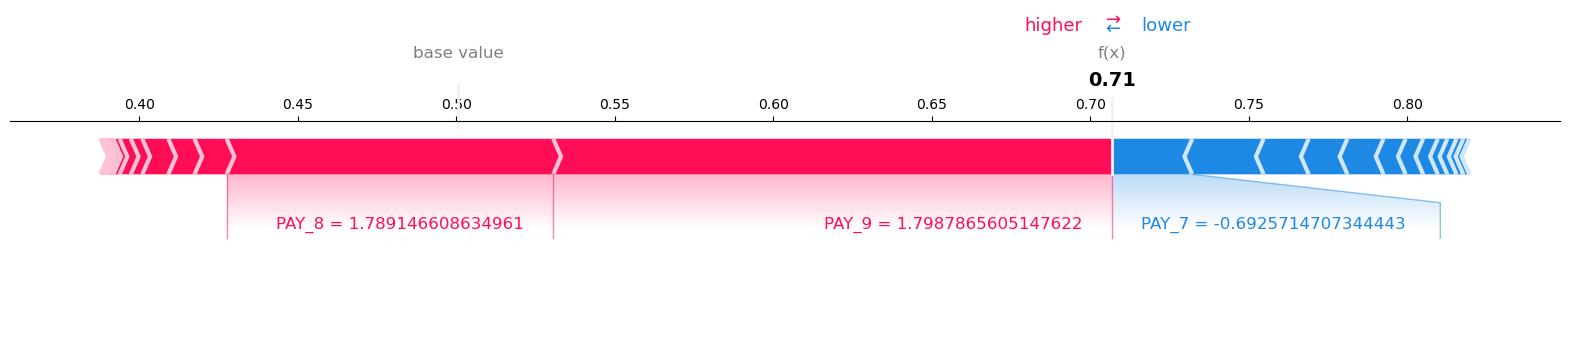

In [63]:
shap.force_plot(
    base_value=rf_explainer.expected_value[1],
    shap_values=test_rf_shap_values[1][ex_default_index, :],
    features=X_test_enc.iloc[ex_default_index, :],
    matplotlib=True,
)

The prediction is pushed by the main factors from the base value to class 1. In this example, the client will likely default. 

<!-- END QUESTION -->

<br><br>

### Summary of results

In [64]:
dict = classification_report(
    y_test, best_rf_pipe.predict(X_test), target_names=["non-default payment", "default payment"], output_dict=True)

results = pd.DataFrame(dict).T
results


,precision,recall,f1-score,support
non-default payment,0.884090,0.798213,0.838960,7052.000000
default payment,0.459552,0.621150,0.528269,1948.000000
accuracy,0.759889,0.759889,0.759889,0.759889
macro avg,0.671821,0.709682,0.683614,9000.000000
weighted avg,0.792201,0.759889,0.771712,9000.000000


After conducting hyperparameter tuning and optimizing the scoring metric for recall, we observed a significant increase in the validation score for the Random Forest model. Our goal was to achieve a high recall score while maintaining a reasonable precision score. Based on our evaluation, we have selected the Random Forest model as our final choice. Both the Random Forest and Logistic Regression models exhibit similar recall scores of 0.627 and 0.648, respectively. However, the Random Forest model outperforms Logistic Regression in terms of precision score, and F1 score, and also demonstrates a lower standard deviation of 0.015. These factors indicate that the Random Forest model strikes a better balance between identifying positive instances and minimizing false positives. By choosing the Random Forest model, we can expect improved overall performance and reliability in predicting positive instances(default payment). This decision takes into account not only the recall score but also other important evaluation metrics.

Dealing with class imbalance is crucial given the highly imbalanced nature of the dataset. While collecting more data would be ideal, it may not always be feasible in real-world scenarios. Alternatively, we can employ resampling techniques to address the class imbalance challenge. In addition to addressing the class imbalance, we can further enhance our approach by optimizing the threshold hyperparameter. The default threshold may not provide the optimal interpretation of predicted probabilities. To achieve higher recall test scores, we can adjust the threshold of the "predict_proba" function to a smaller value, thus identifying more instances of default payments. This adjustment allows us to prioritize capturing positive instances even at the cost of potential false positives. Furthermore, depending on the specific interpretation requirements, we can explore alternative models instead of ensembles to obtain a more interpretable model. This consideration ensures that the model's predictions are easily understandable and explainable, aligning with the desired level of interpretability required for the task at hand.

Our final test score by the best Random forest model has a test f1 score of 0.524, a test recall score of 0.620 and a test precision score of 0.455.

The main takeaway from this project lies in recognizing the significance of data cleaning and thorough dataset analysis prior to model building. These preliminary steps are crucial in ensuring the reliability and effectiveness of the model. Additionally, it is essential to understand the purpose of model predictions in order to decide which metrics to use, as they provide valuable insights into the model's performance.

<!-- END QUESTION -->

<br><br>

![](img/eva-well-done.png)